In [1]:
%matplotlib notebook
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import datetime
from collections import deque
import serial
import struct
import threading

NUMCHANNELS = 1
WINDOWSIZE = 1000

In [2]:
class EMG_Recording:
    def __init__(self):
        self.start_datetime = None
        self.data = []
    
rec = EMG_Recording()
window = None
ser = None

def start_emg():
    global ser
    if ser is None: 
        ser = serial.Serial('COM3', 57600)
        time.sleep(3) # because arduino auto-resets on serial connection
    ser.write(b'start')
    
def read_packet():
    global ser
    fmt = '<' + ('L') + ('H'*NUMCHANNELS)
    try:
        while True:
            if struct.unpack('<B',ser.read(1))[0] is 255:
                break
        return struct.unpack(fmt,ser.read(struct.calcsize(fmt)))
    except:
        return None
    
def _start_data_capture():
    global rec, ser, window
    rec.start_datetime = datetime.datetime.now()
    window = deque(maxlen=WINDOWSIZE)
    for i in range(WINDOWSIZE): 
        window.append((0,0))
    while ser is not None:
        sample = read_packet()
        if sample is not None:
            window.append(sample)
            rec.data.append(sample)

def start_data_capture():
    thread = threading.Thread(target = _start_data_capture)
    thread.start()
    
def stop_emg():
    global ser
    ser.write(b'stop')
    ser.close()
    ser = None

In [3]:
start_emg()
start_data_capture()

<IPython.core.display.Javascript object>


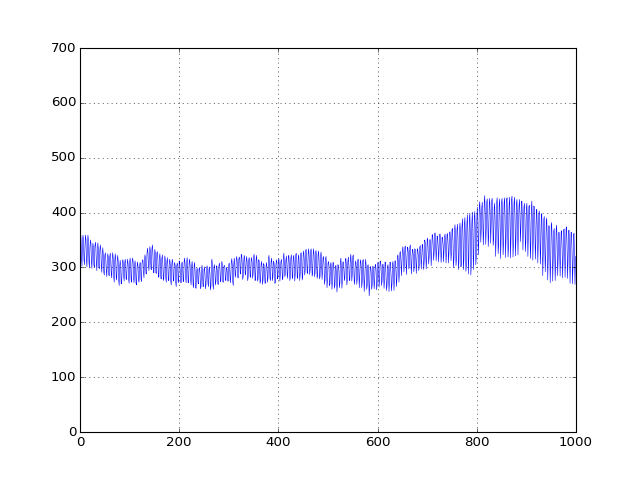

In [4]:
def window_data():
    return [i[1] for i in list(window)]

xdata = range(WINDOWSIZE)
ydata = window_data()

fig, ax = plt.subplots()
line, = ax.plot(xdata, ydata, lw=0.5)
ax.set_ylim(0, 700)
ax.grid()

def run(i):
    ydata = window_data()
    line.set_ydata(ydata)
    return line,

ani = animation.FuncAnimation(fig, run, blit=True, interval=10, repeat=False)
plt.show()

In [5]:
stop_emg()